# Sección 2. Entendimiento y Preparación de los datos

Esta sección tiene como propósito exponer el entendimiento y la preparación de los textos para posteriormente utilizarlos en la implementación de los modelos de aprendizaje. Para la manipulación de los datos se usarán librerias como **pandas** y **numpy**. Para la visualización se utilizarán **matplotlib**, **seaborn** y **WordCloud**.

## 1. Instalación e importación de librerias

### Instalación

In [1]:
#%pip install pandas numpy matplotlib seaborn scikit-learn nltk spacy wordcloud tqdm
#%pip install spacy-langdetect
#!python -m spacy download es_core_news_sm
#%pip install tensorflow
#%pip install keras
#!pip install wordcloud
#!pip install spacy-langdetect
#!python -m spacy download es_core_news_sm
#!pip install tensorflow
#!pip install keras
#!pip install spacy

In [2]:
# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Procesamiento de texto
import re
import string
import spacy
from spacy_langdetect import LanguageDetector
import re
import unicodedata

import nltk
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Modelado y evaluación
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, ConfusionMatrixDisplay,precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Para búsqueda de hiperparámetros
from sklearn.model_selection import GridSearchCV
# Para la validación cruzada
from sklearn.model_selection import KFold 

# Progreso en bucles
from tqdm import tqdm

from collections import Counter
#from ydata_profiling import ProfileReport
from scipy.sparse import hstack

import numpy as np

# Tensor flow para redes neuronales
import tensorflow as tf
from tensorflow import keras

# Importación de los arboles de decisión
from sklearn.tree import DecisionTreeClassifier


# Cargar modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

# Descargar stopwords de NLTK en español
nltk.download('stopwords')
stopwords_es = set(stopwords.words('spanish'))

# Configuración de visualización
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,5)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mgs05\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 2. Perfilamiento y entendimiento de los datos

### Lectura de los datos

Procedemos a cargar los datos y a revisar su estructura.

In [3]:
# Cargar datos
data=pd.read_csv('fake_news_spanish.csv', sep=';', encoding = "utf-8")

news_df = data.copy()

In [4]:
news_df.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57063 entries, 0 to 57062
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           57063 non-null  object
 1   Label        57063 non-null  int64 
 2   Titulo       57047 non-null  object
 3   Descripcion  57063 non-null  object
 4   Fecha        57063 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.2+ MB


In [5]:
news_df.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


Entendemos entonces, que tenemos una variable objetivo llamada *'Label'* la cual determina si una historia es falsa o no. Adicionalmente, identificamos otras variables como el *'Titulo'* de la historia y su *'Descripción'*. Adicionalmente, la *'Fecha'* es probablemente la fecha de publicación. 

### Entendimiento de los Datos

#### Estadísticas descriptivas

El entendimiento de los datos consiste en analizar las estadísticas que describen nuestras variables. En este sentido, haremos un conteo preliminar de las palabras en el título de cada noticia, la moda, el mínimo y el máximo.

In [6]:
news_df['Conteo'] = [len(str(x)) for x in news_df['Titulo']]
news_df['Moda'] = [Counter([word.lower().strip(string.punctuation) for word in (str(i).split(' '))]).most_common()[0][0] for i in news_df['Titulo']]
news_df['Max'] = [[max([len(x) for x in str(i).split(' ')])][0] for i in news_df['Titulo']]
news_df['Min'] = [[min([len(x) for x in str(i).split(' ')])][0] for i in news_df['Titulo']]

news_df.head()

,ID,Label,Titulo,Descripcion,Fecha,Conteo,Moda,Max,Min
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023,77,the,9,2
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023,104,el,10,1
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022,77,el,10,1
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022,110,a,12,1
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018,72,puigdemont,11,2


#### Perfilamiento de los datos

En cuanto al perfilamiento de los datos, se hará uso de ydata profiling para ir aún más a fondo en los datos que buscamos describir.

In [7]:
##profile = ProfileReport(news_df, title="Pandas Profiling Report")
##profile

Como podemos observar, debemos ser muy cuidadosos a la hora de analisar el tema de datos duplicados y demás estadísticas cuando manejamos datos de texto. Hacer una limpieza y preparar los datos vale la pena teniendo en cuenta que la mayoria de valores obtenidos se ven alterados por lo que denominaremos como ruido.

## 3. Preparación de los datos

#### 3.1. Limpieza de datos.

Este código implementa un proceso de preprocesamiento de texto para limpiar datos textuales antes de realizar análisis de texto o procesamiento de lenguaje natural.El preprocesamiento se aplica a dos columnas de un DataFrame (Titulo y Descripcion), generando nuevas columnas con los textos limpios (Titulo_Limpio y Descripcion_Limpia). Este paso es fundamental porque ayuda a reducir el ruido en los datos, mejora la precisión de los modelos y facilita la extracción de información relevante eliminando términos irrelevantes o redundantes.


In [8]:
import nltk
import unicodedata
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

news_df = news_df[["Label", "Titulo", "Descripcion"]]

# Funciones de preprocesamiento
def remove_non_ascii(words):
    """Remueve caracteres no ASCII de una lista de palabras"""
    return [unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore') for word in words if word]

def to_lowercase(words):
    """Convierte todas las palabras a minúsculas"""
    return [word.lower() for word in words if word]

def remove_punctuation(words):
    """Elimina signos de puntuación"""
    return [re.sub(r'[^\w\s]', '', word) for word in words if re.sub(r'[^\w\s]', '', word) != '']

def remove_numbers(words):
    """Elimina los números de la lista de palabras"""
    return [word for word in words if not word.isdigit()]

def remove_stopwords(words):
    """Elimina stopwords en español"""
    return [word for word in words if word not in stopwords_es]

def preprocessing(text):
    """Aplica todas las funciones de limpieza de texto a un string"""
    words = word_tokenize(text, language="spanish")  # Tokenizar con NLTK
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return " ".join(words)  # Retorna el texto limpio como un string

# Aplicar limpieza en el DataFrame
news_df['Titulo_Limpio'] = news_df['Titulo'].astype(str).apply(preprocessing)
news_df['Descripcion_Limpia'] = news_df['Descripcion'].astype(str).apply(preprocessing)

# Comparación antes y después
news_df.head()


,Label,Titulo,Descripcion,Titulo_Limpio,Descripcion_Limpia
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,the guardian va sanchez europa necesita apuest...,diario britanico publico pasado jueves editori...
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revelan gobierno negocio liberacion mireles ca...,revelan gobierno negocio liberacion mireles ca...
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,ahora nunca joan fuster estatuto valenciano cu...,valencianismo convoca castello fiesta grande c...
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",iglesias alienta yolanda diaz erc eh bildu neg...,politica igual negociar empresarios negociar g...
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",puigdemont seria ninguna tragedia repeticion e...,entrevista punt avui lider jxcat desdramatizad...


#### 3.2. Tokenización

Este código realiza la tokenización de texto. Esta tokenización se aplica a las columnas ya limpias del DataFrame (Titulo_Limpio y Descripcion_Limpia), generando nuevas columnas Titulo_Tokens y Descripcion_Tokens, donde cada texto se representa como una lista de palabras. Este paso es crucial porque permite a los modelos de análisis de texto procesar los datos de manera estructurada.


In [9]:
def tokenize_nltk(text):
    return word_tokenize(text, language="spanish")

# Aplicar tokenización en las columnas ya limpias
news_df['Titulo_Tokens'] = news_df['Titulo_Limpio'].astype(str).apply(tokenize_nltk)
news_df['Descripcion_Tokens'] = news_df['Descripcion_Limpia'].astype(str).apply(tokenize_nltk)

# Mostrar ejemplos
print("Comparación después de la tokenización:")
news_df.head()



Comparación después de la tokenización:


,Label,Titulo,Descripcion,Titulo_Limpio,Descripcion_Limpia,Titulo_Tokens,Descripcion_Tokens
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,the guardian va sanchez europa necesita apuest...,diario britanico publico pasado jueves editori...,"[the, guardian, va, sanchez, europa, necesita,...","[diario, britanico, publico, pasado, jueves, e..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revelan gobierno negocio liberacion mireles ca...,revelan gobierno negocio liberacion mireles ca...,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,ahora nunca joan fuster estatuto valenciano cu...,valencianismo convoca castello fiesta grande c...,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castello, fiesta, gra..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",iglesias alienta yolanda diaz erc eh bildu neg...,politica igual negociar empresarios negociar g...,"[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",puigdemont seria ninguna tragedia repeticion e...,entrevista punt avui lider jxcat desdramatizad...,"[puigdemont, seria, ninguna, tragedia, repetic...","[entrevista, punt, avui, lider, jxcat, desdram..."


#### 3.3. Lematización

Este código realiza la normalización del texto aplicando técnicas de stemming y lemmatización. La normalización se aplica a las columnas del DataFrame (Titulo_Tokens y Descripcion_Tokens), generando nuevas columnas Titulo_Normalizado y Descripcion_Normalizada, donde cada palabra es reducida a su raíz. Este paso es fundamental porque mejora la consistencia del texto y facilita el procesamiento de datos en modelos de análisis de texto.

In [10]:


# Descargar recursos necesarios para lematización
#nltk.download('wordnet')
#nltk.download('omw-1.4')

# Crear los objetos para stemming y lematización
stemmer = SnowballStemmer("spanish")
lemmatizer = WordNetLemmatizer()

def stem_words(words):
    """Aplica stemming para eliminar prefijos y sufijos en las palabras"""
    return [stemmer.stem(word) for word in words]

def lemmatize_verbs(words):
    """Aplica lematización para obtener la raíz de los verbos"""
    return [lemmatizer.lemmatize(word, wordnet.VERB) for word in words]

def stem_and_lemmatize(words):
    """Combina stemming y lematización para normalizar los datos"""
    stemmed = stem_words(words)
    lemmatized = lemmatize_verbs(words)
    return list(set(stemmed + lemmatized))  # Se usa set() para evitar duplicados

# Aplicar normalización a las columnas tokenizadas
news_df['Titulo_Normalizado'] = news_df['Titulo_Tokens'].apply(stem_and_lemmatize)
news_df['Descripcion_Normalizada'] = news_df['Descripcion_Tokens'].apply(stem_and_lemmatize)

# Mostrar ejemplos
print("Comparación después de la normalización:")
news_df.head()


Comparación después de la normalización:


,Label,Titulo,Descripcion,Titulo_Limpio,Descripcion_Limpia,Titulo_Tokens,Descripcion_Tokens,Titulo_Normalizado,Descripcion_Normalizada
0,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,the guardian va sanchez europa necesita apuest...,diario britanico publico pasado jueves editori...,"[the, guardian, va, sanchez, europa, necesita,...","[diario, britanico, publico, pasado, jueves, e...","[guardi, europa, va, sanchez, necesit, frut, n...","[editorial, pas, adelant, apoy, alerte, pasado..."
1,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,revelan gobierno negocio liberacion mireles ca...,revelan gobierno negocio liberacion mireles ca...,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel...","[cambio, liberacion, duarte, negoci, revelan, ...","[quedaria, pasar, derech, relataron, volveria,..."
2,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,ahora nunca joan fuster estatuto valenciano cu...,valencianismo convoca castello fiesta grande c...,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castello, fiesta, gra...","[cumple, cumpl, ahora, nunca, estatuto, fuster...","[conmemor, plana, plena, plen, batalla, castel..."
3,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",iglesias alienta yolanda diaz erc eh bildu neg...,politica igual negociar empresarios negociar g...,"[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc...","[fundamental, investidura, bloqu, diaz, negoci...","[parlamentari, negoci, polit, grupos, grup, em..."
4,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",puigdemont seria ninguna tragedia repeticion e...,entrevista punt avui lider jxcat desdramatizad...,"[puigdemont, seria, ninguna, tragedia, repetic...","[entrevista, punt, avui, lider, jxcat, desdram...","[ninguna, seri, seria, tragedi, elecciones, el...","[teo, escenario, reticent, ege, investidura, d..."


Se mostrarán solamente: Los tokens del título, los tokens de la descripción, el titulo normalizado y la descripción normalizada.

In [11]:
processed_df = news_df[['Label', 'Titulo_Tokens', 'Descripcion_Tokens', 'Titulo_Normalizado', 'Descripcion_Normalizada']]
processed_df.head()

,Label,Titulo_Tokens,Descripcion_Tokens,Titulo_Normalizado,Descripcion_Normalizada
0,1,"[the, guardian, va, sanchez, europa, necesita,...","[diario, britanico, publico, pasado, jueves, e...","[guardi, europa, va, sanchez, necesit, frut, n...","[editorial, pas, adelant, apoy, alerte, pasado..."
1,0,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel...","[cambio, liberacion, duarte, negoci, revelan, ...","[quedaria, pasar, derech, relataron, volveria,..."
2,1,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castello, fiesta, gra...","[cumple, cumpl, ahora, nunca, estatuto, fuster...","[conmemor, plana, plena, plen, batalla, castel..."
3,1,"[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc...","[fundamental, investidura, bloqu, diaz, negoci...","[parlamentari, negoci, polit, grupos, grup, em..."
4,0,"[puigdemont, seria, ninguna, tragedia, repetic...","[entrevista, punt, avui, lider, jxcat, desdram...","[ninguna, seri, seria, tragedi, elecciones, el...","[teo, escenario, reticent, ege, investidura, d..."


Ahora unificaremos los titulos y las descripciones normalizadas.

In [12]:
# Hacer copia del dataframe procesado
processed_news_df = processed_df.copy()

# Convertir las listas de palabras en texto separado por espacios en las columnas Titulo_Normalizado y Descripcion_Normalizada
processed_news_df['Titulo_Normalizado'] = processed_news_df['Titulo_Normalizado'].apply(lambda tokens: " ".join(tokens))
processed_news_df['Descripcion_Normalizada'] = processed_news_df['Descripcion_Normalizada'].apply(lambda tokens: " ".join(tokens))

# Mostrar algunos ejemplos para verificar el cambio
processed_news_df.head()

,Label,Titulo_Tokens,Descripcion_Tokens,Titulo_Normalizado,Descripcion_Normalizada
0,1,"[the, guardian, va, sanchez, europa, necesita,...","[diario, britanico, publico, pasado, jueves, e...",guardi europa va sanchez necesit frut necesita...,editorial pas adelant apoy alerte pasado presi...
1,0,"[revelan, gobierno, negocio, liberacion, mirel...","[revelan, gobierno, negocio, liberacion, mirel...",cambio liberacion duarte negoci revelan javi n...,quedaria pasar derech relataron volveria algui...
2,1,"[ahora, nunca, joan, fuster, estatuto, valenci...","[valencianismo, convoca, castello, fiesta, gra...",cumple cumpl ahora nunca estatuto fuster joan ...,conmemor plana plena plen batalla castello cas...
3,1,"[iglesias, alienta, yolanda, diaz, erc, eh, bi...","[politica, igual, negociar, empresarios, negoc...",fundamental investidura bloqu diaz negociar al...,parlamentari negoci polit grupos grup empresar...
4,0,"[puigdemont, seria, ninguna, tragedia, repetic...","[entrevista, punt, avui, lider, jxcat, desdram...",ninguna seri seria tragedi elecciones eleccion...,teo escenario reticent ege investidura desdram...


# Sección 3. Modelado y evaluación.

## 4. Construcción de Modelos

Como los datos que tenemos son datos de texto, debemos de alguna maner convertir estos datos en valores interpretables por el modelo para generar información relevante que podamos interpretar. En este caso, usaremos a nuestro favor la **vectorización de texto** a partir del método TF-IDF ya que es una opción balanceada entre simplicidad y efectividad. La idea es convertir los textos de 'Titulo_Normalizado' y 'Descripcion_Normalizada' en vectores numéricos usando TF-IDF y luego usarlos para entrenar un modelo de clasificación. 

#### 4.1 Transformación TF-IDF

In [13]:
# Definimos el vectorizador TF-IDF
vectorizer = TfidfVectorizer()  # Limitamos el número de características para evitar alta dimensionalidad

# Aplicamos la transformación TF-IDF a las columnas normalizadas
titulo_tfidf = vectorizer.fit_transform(processed_news_df['Titulo_Normalizado'])
descripcion_tfidf = vectorizer.fit_transform(processed_news_df['Descripcion_Normalizada'])

# Concatenamos ambas representaciones para tener una única matriz de características
X = hstack([titulo_tfidf, descripcion_tfidf])
# Definimos la variable objetivo
y = processed_news_df['Label']

# Mostramos la forma de la matriz final
print("Dimensión de la matriz de características X:", X.shape)
print("Dimensión de la variable objetivo y:", y.shape)

Dimensión de la matriz de características X: (57063, 91339)
Dimensión de la variable objetivo y: (57063,)


In [14]:
# AUXILIAR

# Aplicamos la transformación TF-IDF a las columnas normalizadas
titulo_tfidf = vectorizer.fit_transform(processed_news_df['Titulo_Normalizado'])
descripcion_tfidf = vectorizer.fit_transform(processed_news_df['Descripcion_Normalizada'])

# Concatenamos ambas representaciones para tener una única matriz de características
X = hstack([titulo_tfidf, descripcion_tfidf])

#### 4.2 Regresión Logística - Entrenamiento del primer modelo de clasificación 
**Elaborado por:** Santiago Casasbuenas.

Utilizaremos un modelo clásico de Regresión Logística, ya que es simple, eficiente y suele funcionar bien en tareas de clasificación de texto.

In [15]:
# Dividimos los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Inicializamos y entrenamos el modelo de Regresión Logística
modelo = LogisticRegression(max_iter=1000)  # Aumentamos las iteraciones para asegurar convergencia
modelo.fit(X_train, y_train)

# Hacemos predicciones sobre el conjunto de prueba
y_pred = modelo.predict(X_test)

# Evaluamos el modelo con una matriz de confusión y métricas de desempeño
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

##### 4.2.1 Resultados de la Regresión Logística

##### 4.2.2 Reporte de Clasificación

In [16]:
# Mostramos los resultados
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)

Exactitud: 0.89
Recall: 0.9632086851628469
Precisión: 0.8637101135749053
Puntuación F1: 0.9107499287140006

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      4781
           1       0.86      0.96      0.91      6632

    accuracy                           0.89     11413
   macro avg       0.90      0.88      0.88     11413
weighted avg       0.90      0.89      0.89     11413



**Análisis de Métricas**
- **Exactitud:** El 89% de las noticias fueron clasificadas correctamente. Sin embargo, esta métrica no siempre refleja bien el rendimiento en problemas desbalanceados.

- **Recall:** El 96% de las noticias verdaderas fueron correctamente identificadas como verdaderas. El 79% de las noticias falsas fueron correctamente identificadas como falsas. El problema principal es que el modelo no está detectando bien las noticias falsas (21% de error en recall para 0.)

- **Presición:** El 86% de las noticias clasificadas como verdaderas realmente son verdaderas (lo cual indica que hay un error del 14%). el 94% de las noticias clasificadas como falsas realmente son falsas.

- **Puntuación F1:** Un valor más alto significa un mejor balance entre detectar correctamente noticias falsas y evitar clasificar noticias reales como falsas. El modelo tiene un mejor desempeño en la detección de noticias verdaderas (91%) que en la detección de noticias falsas (86%). Esto significa que el modelo puede pasar muchas noticias falsas como verdaderas (falsos negativos).

##### 4.2.3 Matríz de Confusión

In [17]:
cm = confusion_matrix(y_test, y_pred)

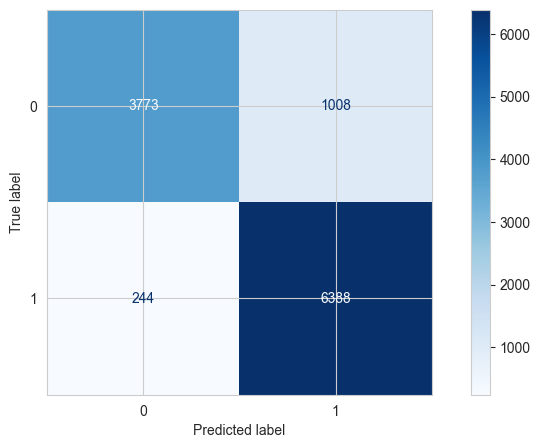

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=modelo.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

**Explicación de los valores del modelo**

- **Verdaderos Negativos (3773):** Noticias falsas *correctamente* identificadas como falsas.

- **Falsos Positivos (1008):** Noticias verdaderas clasificadad *incorrectamente* como falsas.

- **Falsos Negativos (244):** Noticias falsas clasificadas *incorrectamente* como verdaderas.

- **Verdaderos Positivos (6388):** Noticias verdaderas *correctamente* identificadas como verdaderas.

##### 4.2.4 Conclusiones iniciales

1. El modelo es confiable para detectar noticias verdaderas (96% recall), pero tiene problemas a la hora de detectar noticias falsas (solo 79% de recall).

2. El principal problema son los falsos positivos (1,008 noticias verdaderas clasificadas erróneamente como falsas).

3. Si el objetivo es detectar la mayor cantidad posible de noticias falsas, el modelo debe ser ajustado para mejorar su recall.

##### 4.2.5 Modificación del Umbral de clasificación

Actualmente, el umbral de clasificación para la detección de noticias es de 0.5, esto significa que si la probabilidad de una noticia de ser verdadera es mayor al 50% se clasifica como verdadera. Podemos entonces, disminuir este umbral para que el modelo sea más estricto al clasificar noticias como verdaderas, aumentando así la detección de noticias falsas.

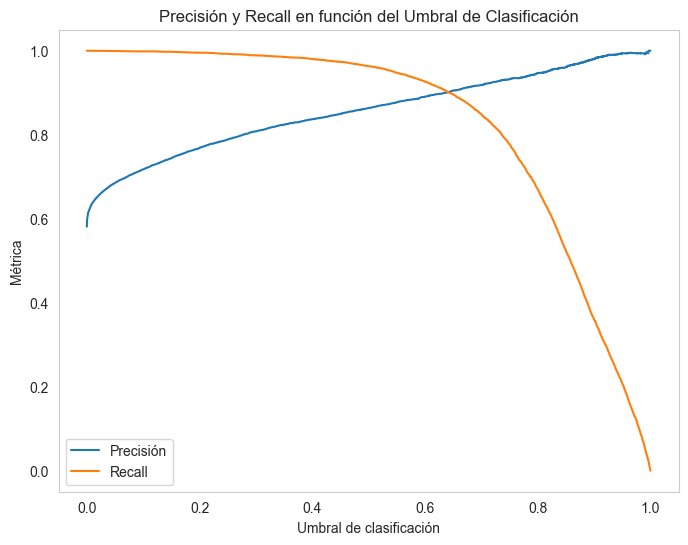

In [19]:
# Obtenemos las probabilidades de predicción en el conjunto de prueba
y_prob = modelo.predict_proba(X_test)[:, 1]  # Probabilidad de ser noticia verdadera (Clase 1)

# Calculamos Precision, Recall y Umbrales automáticamente
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Graficamos Precision-Recall para diferentes umbrales
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], label="Precisión")
plt.plot(thresholds, recalls[:-1], label="Recall")
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.legend()
plt.title("Precisión y Recall en función del Umbral de Clasificación")
plt.grid()
plt.show()


**Análisis de la curva Presición-Recall en función del Umbral de Clasificación**

El punto de equilibrio lo encontramos entre 0.6 y 0.7 podemos empezar a experimentar con estos valores y evaluar los resultados.

In [20]:
# Definimos el nuevo umbral
nuevo_umbral = 0.6

# Aplicamos el nuevo umbral a las predicciones
y_pred_ajustado = (y_prob >= nuevo_umbral).astype(int)

# Calculamos las nuevas métricas
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

conf_matrix_ajustada = confusion_matrix(y_test, y_pred_ajustado)
accuracy_ajustada = accuracy_score(y_test, y_pred_ajustado)
classification_rep_ajustado = classification_report(y_test, y_pred_ajustado)

# Mostramos los resultados ajustados
print("Matriz de Confusión (Umbral 0.6):")
print(conf_matrix_ajustada)
print("\nReporte de Clasificación (Umbral 0.6):")
print(classification_rep_ajustado)
print(f"\nExactitud del modelo (Umbral 0.6): {accuracy_ajustada:.4f}")


Matriz de Confusión (Umbral 0.6):
[[4026  755]
 [ 488 6144]]

Reporte de Clasificación (Umbral 0.6):
              precision    recall  f1-score   support

           0       0.89      0.84      0.87      4781
           1       0.89      0.93      0.91      6632

    accuracy                           0.89     11413
   macro avg       0.89      0.88      0.89     11413
weighted avg       0.89      0.89      0.89     11413


Exactitud del modelo (Umbral 0.6): 0.8911


Lo primero que identificamos es que el 93% de las noticias verdaderas fueron correctamente identificadas como verdaderas. El **84% de las noticias falsas fueron correctamente identificadas como falsas**, reduciendo así el error a 16%. 

In [21]:
cm_modificada = confusion_matrix(y_test, y_pred_ajustado)

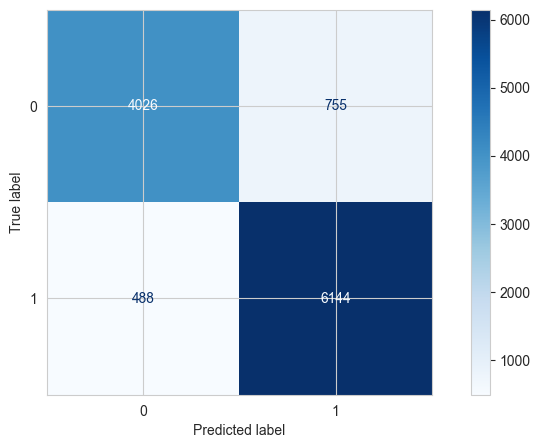

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm_modificada, display_labels=modelo.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

La matríz de confusión también presenta resultados bastante satisfactorios, reduciendo los falsos negativos a cambio de el aumento en los falsos positivos, pero a su vez, aumentando también las noticias tanto falsas como verdaderas que se clasificaron correctamente. Concluimos un buen tradeoff y un modelo que puede cumplir con los estándares del negocio.

#### 4.3. Red neuronal
**Elaborado por:** Manuel Gómez

##### 4.3.1. Definición de la Arquitectura de la Red Neuronal

**Capa de entrada:** Recibe los datos (matriz TF-IDF con características numéricas).

**Capas ocultas:** Transforman la información utilizando activaciones ReLU y dropout para evitar sobreajuste.

**Capa de salida:** Genera la predicción final utilizando activación sigmoide.

**ReLU** (Unidad Lineal Rectificada): Es una función de activación que se usa en las redes neuronales artificiales y en el aprendizaje profundo. Es una de las funciones de activación más populares y utilizadas. Lo que hace es transformar el resultado con un algortimo relativamente sencillo. Si el valor de entrada es menor o igual a 0, muestra 0. Si el valor de entrada es mayor a 0, muestra el valor de entrada.

En otras palabras: 

$$ f(x) = \max(0, x) $$

- Si la entrada $x$ es positiva, la salida es **igual a** $x$.
- Si la entrada $x$ es negativa o 0, la salida es 0.

**Ventajas:** Evita el problema del "desvanecimiento del gradiente" que ocurre con activaciones como sigmoide o tanh en capas ocultas. O, hace que la red aprenda mejor al mantener la fuerza de la señal, evitando que la información se debilite al atravesar muchas capas.

**Desventaja:** Neuronas pueden "morir" si quedan atrapadas en valores negativos (solucionado en variantes como Leaky ReLU).

**Sigmoid en la capa de salida:** Transformamos números reales continuos en un valor que pertenece a un rango entre 0 y 1. La idea es entonces que los valores de entrada pequeños den como resultado salidas cercanas a 0 y los valores de entrada grandes den como resultado salidas cercanas a 1.


Se expresa como:

$$
\sigma(x)=\frac{1}{1+e^{-x}}
$$

- Convierte cualquier número en un valor entre 0 y 1.
- Ideal para clasificación binaria porque se puede interpretar como una probabilidad.
- Si la salida es cercana a 1, el modelo predice "verdadero".
- Si la salida es cercana a 0, el modelo predice "falso".

El ejemplo más óptimo por consiguiente, puede ser representado de la siguiente forma:

Entrada → Capa oculta (ReLU) → Capa oculta (ReLU) → Capa de salida (Sigmoide) → Predicción (0 o 1)

##### 4.3.2. Optimizador Adam y Función de Pérdida

**¿Cómo funciona Adam?**

- Adam (Adaptive Moment Estimation) es un algoritmo de optimización que ajusta los pesos de la red neuronal para minimizar el error.

- Usa una combinación de dos conceptos:
    1. **Momentum:** Evita que el modelo se quede atrapado en mínimos locales.
    2. **RMSprop:** Ajusta automáticamente la tasa de aprendizaje.

- Es una versión mejorada de SGD (Stochastic Gradient Descent), más rápida y precisa en la mayoría de los casos.

- Se adapta bien a diferentes tipos de datos sin necesidad de ajustar mucho los hiperparámetros.

**Función de Pérdida: Binary Crossentropy**

Dado que estamos resolviendo un problema de clasificación binaria (noticia falsa o verdadera), la función de pérdida que usamos es binary crossentropy.

Fórmula de Binary Crossentropy:

$$
\text{Loss} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
$$

El día que entendamos la matemática detrás... Pues, no estaremos en estas. Por ahora, podemos dar una explicación simple de lo que hace dicha función:

- $y_i$ es la **etiqueta real** (0 o 1).

- $\hat{y}_i$ es la **predicción del modelo** (probabilidad entre 0 y 1).

- Si la predicción es **muy diferente** del valor real, la pérdida **será alta**. Esto quiere decir que el modelo está cometiendo **muchos errores**.

- Si la predicción es **muy cercana** al valor real, la pérdida **será baja**. Esto quiere decir que el modelo está prediciendo **correctamente**.

##### 4.3.3. Entrenamiento de la red neuronal.
Como estamos trabajando con un problema de clasificación binaria, necesitamos un modelo capaz de capturar patrones en los datos y realizar predicciones con precisión. En este caso, utilizamos una red neuronal artificial (RNA), una arquitectura flexible y potente para el aprendizaje automático. La red está compuesta por tres capas densas: la primera con 128 neuronas y la segunda con 64, ambas activadas con **ReLU para mejorar el aprendizaje no lineal**. Para evitar el sobreajuste, se incorpora Dropout con un 30% de desactivación de neuronas en cada capa oculta. Finalmente, la capa de salida tiene una única neurona con activación sigmoide, lo que permite obtener una probabilidad para clasificar cada noticia como verdadera o falsa.

In [23]:
# Dividimos los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Definimos la arquitectura de la red neuronal
modelo_nn = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X.shape[1],)),
    keras.layers.Dropout(0.3),  # Regularización para evitar sobreajuste
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria
])

# Compilamos el modelo
modelo_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenamos el modelo
history = modelo_nn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Evaluamos el modelo en el conjunto de prueba
y_pred_prob = modelo_nn.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculamos métricas de evaluación
conf_matrix_nn = confusion_matrix(y_test, y_pred)
accuracy_nn = accuracy_score(y_test, y_pred)
classification_rep_nn = classification_report(y_test, y_pred)

# Mostramos los resultados
print("Matriz de Confusión:")
print(conf_matrix_nn)
print("\nReporte de Clasificación:")
print(classification_rep_nn)
print(f"\nExactitud del modelo: {accuracy_nn:.4f}")

C:\Users\mgs05\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 72s 49ms/step - accuracy: 0.8039 - loss: 0.4281 - val_accuracy: 0.8735 - val_loss: 0.3027
Epoch 2/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 66s 46ms/step - accuracy: 0.9301 - loss: 0.1720 - val_accuracy: 0.8734 - val_loss: 0.3216
Epoch 3/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.9505 - loss: 0.1072 - val_accuracy: 0.8709 - val_loss: 0.3787
Epoch 4/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 66s 46ms/step - accuracy: 0.9630 - loss: 0.0764 - val_accuracy: 0.8732 - val_loss: 0.4672
Epoch 5/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 66s 46ms/step - accuracy: 0.9724 - loss: 0.0601 - val_accuracy: 0.8772 - val_loss: 0.5136
Epoch 6/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.9730 - loss: 0.0535 - val_accuracy: 0.8757 - val_loss: 0.5888
Epoch 7/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.9795 - loss: 0.0456 - val_accuracy: 0.8801 - val_loss: 0.5830
Epoch 8/10
1427/1427 ━━━━━━━━━━━━━━━━━━━━ 65s 46ms/step - accuracy: 0.9812 -

In [24]:

def plot_confusion_matrix(conf_matrix, labels=['Falso', 'Verdadero']):
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, linewidths=0.5, linecolor='black')
    
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()



#Acuracy
accuracy_nn = accuracy_score(y_test, y_pred)
print("Exactitud: %.2f" % accuracy_nn)

Exactitud: 0.88


Explicación de los valores del modelo

* Verdaderos Negativos (3968): Noticias falsas correctamente identificadas como falsas.
* Falsos Positivos (813): Noticias verdaderas clasificadas incorrectamente como falsas.
* Falsos Negativos (534): Noticias falsas clasificadas incorrectamente como verdaderas.
* Verdaderos Positivos (6098): Noticias verdaderas correctamente identificadas como verdaderas.

Conslusiones iniciales:
* El modelo es confiable para detectar noticias verdaderas (92% recall), pero tiene dificultades para identificar noticias falsas (solo 88% de recall).

* El principal problema son los falsos negativos (534 noticias falsas clasificadas erróneamente como verdaderas), lo que indica que algunas noticias falsas podrían pasar desapercibidas.

* Aunque la precisión general del modelo es alta, si el objetivo es minimizar la propagación de noticias falsas, se debe mejorar el recall en la detección de estas mediante ajustes en el umbral de clasificación o técnicas de balanceo de datos.

##### 4.3.4. Modificación del umbral de decisión

357/357 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


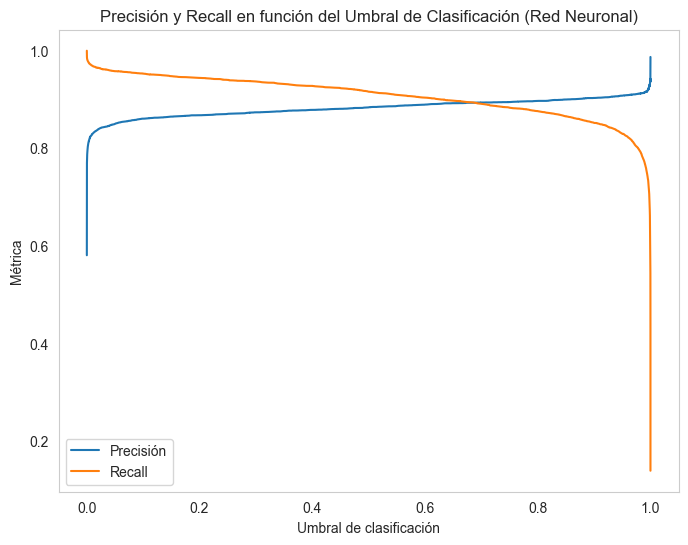

In [25]:
# Obtenemos las probabilidades de predicción en el conjunto de prueba
y_prob_nn = modelo_nn.predict(X_test)[:, 0]  # Probabilidad de ser noticia verdadera (Clase 1)

# Calculamos Precision, Recall y Umbrales automáticamente
precisions_nn, recalls_nn, thresholds_nn = precision_recall_curve(y_test, y_prob_nn)

# Graficamos Precision-Recall para diferentes umbrales
plt.figure(figsize=(8, 6))
plt.plot(thresholds_nn, precisions_nn[:-1], label="Precisión")
plt.plot(thresholds_nn, recalls_nn[:-1], label="Recall")
plt.xlabel("Umbral de clasificación")
plt.ylabel("Métrica")
plt.legend()
plt.title("Precisión y Recall en función del Umbral de Clasificación (Red Neuronal)")
plt.grid()
plt.show()

El punto de equilibrio lo encontramos entre 0.6 y 0.8 podemos empezar a experimentar con estos valores y evaluar los resultados.

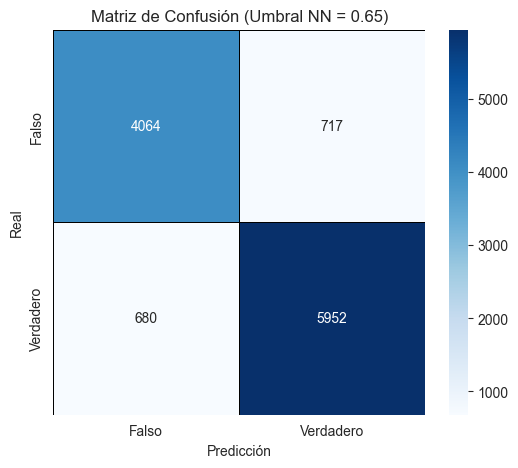

Exactitud con nuevo umbral NN: 0.8776

Nueva Matriz de Confusión (NN):
[[4064  717]
 [ 680 5952]]

Nuevo Reporte de Clasificación (NN):
              precision    recall  f1-score   support

           0       0.86      0.85      0.85      4781
           1       0.89      0.90      0.89      6632

    accuracy                           0.88     11413
   macro avg       0.87      0.87      0.87     11413
weighted avg       0.88      0.88      0.88     11413



In [26]:
# Definir un nuevo umbral específico para la red neuronal
nuevo_umbral_nn = 0.65  

# Aplicar el nuevo umbral para clasificar
y_pred_nuevo_nn = (y_prob_nn >= nuevo_umbral_nn).astype(int)

# Calcular la nueva matriz de confusión
conf_matrix_nuevo_nn = confusion_matrix(y_test, y_pred_nuevo_nn)

# Visualización de la nueva matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_nuevo_nn, annot=True, fmt='d', cmap='Blues', xticklabels=['Falso', 'Verdadero'], 
            yticklabels=['Falso', 'Verdadero'], linewidths=0.5, linecolor='black')

plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (Umbral NN = {nuevo_umbral_nn})')
plt.show()

# Calcular nuevas métricas
accuracy_nuevo_nn = accuracy_score(y_test, y_pred_nuevo_nn)
classification_rep_nuevo_nn = classification_report(y_test, y_pred_nuevo_nn)

print(f"Exactitud con nuevo umbral NN: {accuracy_nuevo_nn:.4f}")
print("\nNueva Matriz de Confusión (NN):")
print(conf_matrix_nuevo_nn)
print("\nNuevo Reporte de Clasificación (NN):")
print(classification_rep_nuevo_nn)

**Análisis de los nuevos resultados:**
El nuevo umbral de 0.65 reduce los falsos positivos (de 813 a 733), lo que mejora la precisión al clasificar noticias falsas, pero también aumenta los falsos negativos (de 534 a 690), lo que significa que más noticias falsas son clasificadas incorrectamente como verdaderas. Si el objetivo es minimizar la propagación de noticias falsas, el umbral anterior de 0.5 es mejor, ya que detecta más noticias falsas correctamente. En cambio, si se busca evitar clasificar noticias verdaderas como falsas, el umbral 0.65 es más adecuado

#### 4.4 Arboles de Decisión - Entrenamiento del tercer modelo de clasificación
**Elaborado por:** Juan Pablo Castro

##### 4.4.1 Entrenamiento de arbol de decisión
Se va a entrenar usando un arbol de decisión, ya que es una buena alternativa para hacer modelos de clasificación, y es sencillo de implementar y análisar.

In [27]:
# Creación del objeto de arbol de decisión.
arbol = DecisionTreeClassifier(criterion='entropy', max_depth = 4, random_state = 0)
arbol

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=0)

In [28]:
# Entrenamiento del modelo de arbol de decisión con los datos de entrenamiento.
arbol = arbol.fit(X_train,y_train)

In [29]:
# Determinamos las predicciones del modelo sobre el conjunto test.
y_pred = arbol.predict(X_test)

##### 4.4.2 Resultados del primer árbol

In [30]:
# Evaluamos el modelo con una matriz de confusión y métricas de desempeño
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [31]:
# Mostramos los resultados
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)

Exactitud: 0.71
Recall: 0.9965319662243667
Precisión: 0.6700800973334685
Puntuación F1: 0.801333737496211

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.99      0.32      0.48      4781
           1       0.67      1.00      0.80      6632

    accuracy                           0.71     11413
   macro avg       0.83      0.66      0.64     11413
weighted avg       0.80      0.71      0.67     11413



Como se puede evidenciar, el modelo tiene un score muy bajo para el recall. Esto se ve mejor evidenciado en la matriz de confusión:

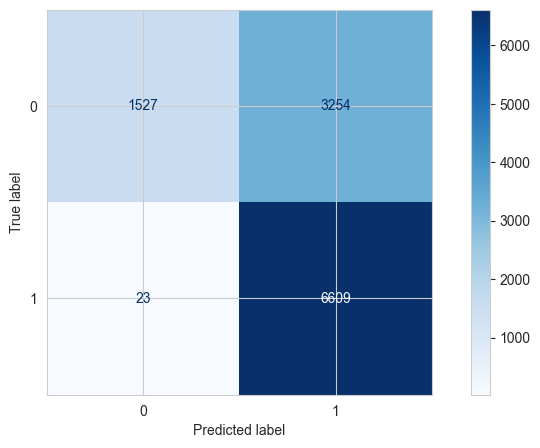

In [32]:
# Se puede visualizar la matriz de confusión
#plot_confusion_matrix(arbol, X_test, Y_test) 
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

**Explicación de los valores del modelo**

- **Verdaderos Negativos (1527):** Noticias falsas *correctamente* identificadas como falsas.

- **Falsos Positivos (3253):** Noticias verdaderas clasificadad *incorrectamente* como falsas.

- **Falsos Negativos (23):** Noticias falsas clasificadas *incorrectamente* como verdaderas.

- **Verdaderos Positivos (6609):** Noticias verdaderas *correctamente* identificadas como verdaderas.

##### 4.4.3 Conclusiones iniciales

1. El modelo es confiable para detectar noticias verdaderas (96% recall), pero parece ser porque predice que la gran mayoría de noticias son verdaderas.

2. El principal problema son los falsos positivos (3254 noticias verdaderas clasificadas erróneamente como falsas).

3. Si el objetivo es detectar la mayor cantidad posible de noticias falsas, el modelo debe ser ajustado para mejorar su recall a una gran medida.

##### 4.4.4 ajuste hiperparametros

Actualmente, no se tiene en cuenta la mejor selección de hiperparametros para el arbol, por lo que se usarán las herramientas de scikit learn para encontrarlos (y ahorrarnos la prueba y error) y luego analisar los resultados:

In [33]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [34]:
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar. 
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[4,6,8,10,20]}

In [35]:
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [36]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
# Ajuste del modelo
mejor_modelo.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 6, 8, 10, 20]})

In [37]:
# Podemos ver cuál fue el resultado de la búsqueda (mejores valores de hiperparámetros)
mejor_modelo.best_params_

{'criterion': 'gini', 'max_depth': 20}

In [38]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(X_train)
y_pred_test = arbol_final.predict(X_test)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_train, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_test))

Exactitud sobre entrenamiento: 0.86
Exactitud sobre test: 0.85


In [39]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.65      0.78      4781
           1       0.80      0.99      0.88      6632

    accuracy                           0.85     11413
   macro avg       0.89      0.82      0.83     11413
weighted avg       0.87      0.85      0.84     11413



In [40]:
# Creación del objeto de arbol de decisión final.
arbol = DecisionTreeClassifier(criterion='gini', max_depth = 20, random_state = 0)
arbol

DecisionTreeClassifier(max_depth=20, random_state=0)

In [41]:
# Entrenamiento del modelo de arbol de decisión con los datos de entrenamiento.
arbol = arbol.fit(X_train,y_train)

In [42]:
# Determinamos las predicciones del modelo sobre el conjunto test.
y_pred = arbol.predict(X_test)

In [43]:
# Evaluamos el modelo con una matriz de confusión y métricas de desempeño
conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

In [44]:
# Mostramos los resultados
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test,y_pred)))
print("Precisión: {}".format(precision_score(y_test,y_pred)))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred)))

print("\nReporte de Clasificación:")
print(classification_rep)

Exactitud: 0.85
Recall: 0.9873341375150784
Precisión: 0.7986339797536285
Puntuación F1: 0.883015305778437

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      4781
           1       0.80      0.99      0.88      6632

    accuracy                           0.85     11413
   macro avg       0.89      0.82      0.83     11413
weighted avg       0.87      0.85      0.84     11413



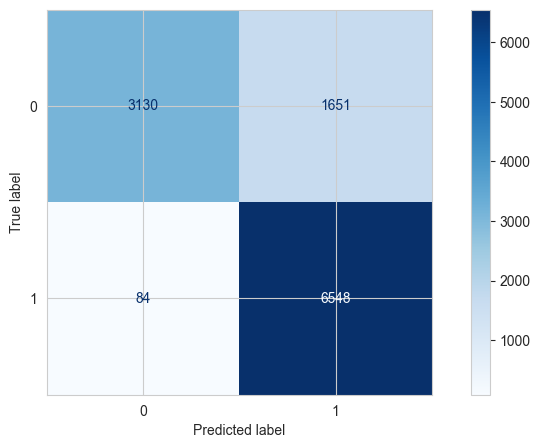

In [45]:
# Se genera la matriz de confusión
cm = confusion_matrix(y_test, y_pred_test)
# Se puede visualizar la matriz de confusión
#plot_confusion_matrix(arbol, X_test, Y_test)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

Se puede ver que el nuevo arbol con los nuevos hipervisores tiene una mejora muy notoria para bajar el numero de falsos positivos, sin embargo, sigue siendo muy pobre en comparado a los demás modelos.

## 5. Datos de prueba compartidos del regresión logística.

In [46]:
# Crear una copia del DataFrame original con solo las filas del conjunto de prueba
news_df_copy = news_df.iloc[y_test.index].copy()

# Seleccionar solo las columnas necesarias
news_df_copy = news_df_copy[["Label", "Titulo", "Descripcion"]]

# Agregar la etiqueta predicha basada en el umbral ajustado
news_df_copy["Etiqueta_Predicha"] = y_pred_ajustado

# Mostrar las primeras filas del DataFrame con la nueva columna
print(news_df_copy.head())

# Opcional: Guardar el DataFrame con las etiquetas predichas
#news_df_copy.to_csv("news_predictions_with_labels.csv", index=False)


       Label                                             Titulo  \
7120       1  Más de 800.000 personas piden al INE que no le...   
39360      0  Gobierno y Unidos PP negocian derogar el copag...   
46373      1  La asociación conservadora de la Guardia Civil...   
22453      1  Teresa Rodríguez duda de que Unidas Podemos se...   
11903      0  Coalición Canaria ficha al abogado de los Jord...   

                                             Descripcion  Etiqueta_Predicha  
7120   Las peticiones recibidas a partir del 7 de oct...                  1  
39360  Esta es la primera de las reuniones tras el ac...                  0  
46373  La Unión de Guardias Civiles (UGC) no cumple l...                  1  
22453  No he entendido bien ese ofrecimiento. Si tú q...                  1  
11903  Juan José Aizcorbe Torra, que defendió a la fa...                  0  
